# Preço de Diamantes - Regressão Linear

### Importando Bibliotecas

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats
import statsmodels
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms


### Objetivo

Criar mum modelo de regressão linear simples que possa estimar o preço de diamante baseado em suas características

### Fonte de Dados

Base de dados sobre com diversas características de diferentes diamantes com seus respsctivos preços
 
https://www.kaggle.com/datasets/vittoriogiatti/diamondprices/

### Dicionário de Dados

In [3]:
df = pd.read_csv("DiamondsPrices.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


* carat: refer-se aos quilates da pedra, unidade de peso, 1 quilate equivale a 200mg
* cut: um score de formato da pedra em termos de "usabilidade" e poder de venda
* color: escala internacional de cores de diamantes, baseada no nível de transparência
* clarity: escala internacional de clareza do diamanante, baseada no número de impurezas
* depth: formato em porcentagem, z / x, é um parâmetro comum na indústria
* table: formato em porcentagem, z / a (variável a não presente nesse dataset)
* price: preço em dólares
* x: comprimento do diamante em milímetros
* y: largura do diamante em milímetros
* z: profundidade do diamante em milímetros

### Análise e Tratamento de Dados

Número de linhas e colunas

In [4]:
df.shape

(53940, 10)

Tipo dos dados

In [5]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

Checagem de valores nulos

In [7]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Checando valores duplicados

In [11]:
df[df.duplicated()]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


Limpando valores duplicados

In [12]:
dados = df.drop_duplicates()

Medidas da base de dados

In [20]:
dados.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Scatter plot para verificar a distribuição dos dados

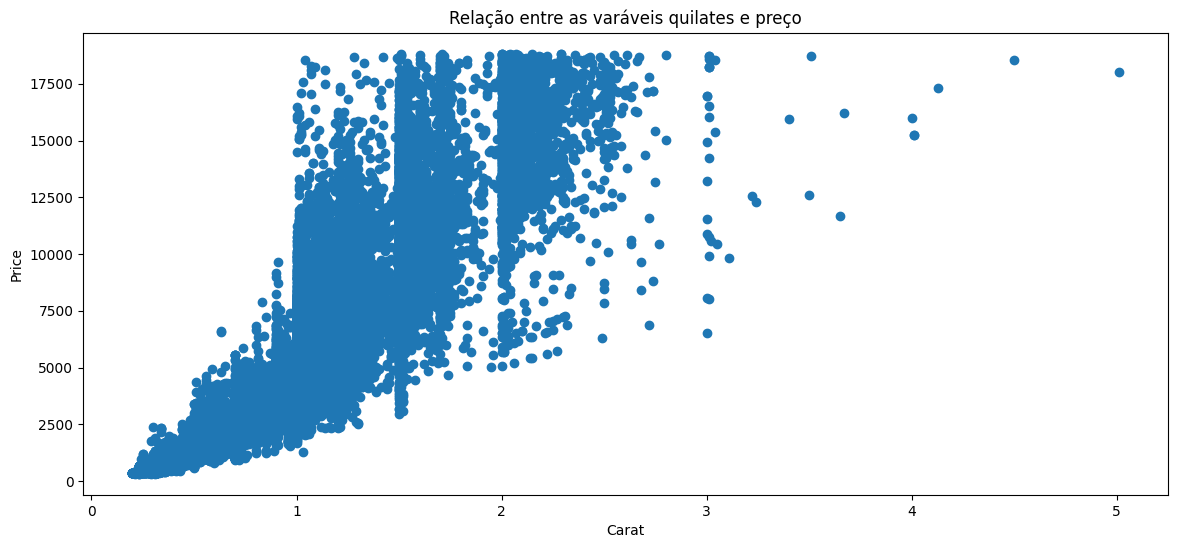

In [51]:
plt.figure(figsize=(14, 6))

plt.scatter(dados.carat, dados.price)
plt.title('Relação entre as varáveis quilates e preço')
plt.xlabel('Carat')
plt.ylabel('Price')

plt.show()

É possível notar que há muitos outliers nessa base de dados, por isso vamo removê-los usando o IQR (Intervalo entre Quartis)

https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_IQR.htm#PFUSU-GUID-CF37CAEA-730B-4346-801E-64612719FF6B

In [55]:
# Calculando os quartis (Q1 e Q3) para 'carat' e 'price'
Q1_carat, Q3_carat = dados['carat'].quantile(0.25), dados['carat'].quantile(0.75)
Q1_price, Q3_price = dados['price'].quantile(0.25), dados['price'].quantile(0.75)

# Calculando o IQR para 'carat' e 'price'
IQR_carat = Q3_carat - Q1_carat
IQR_price = Q3_price - Q1_price

# Definindo os limites superior e inferior para 'carat' e 'price'
limite_inf_carat = Q1_carat - 1.5 * IQR_carat
limite_sup_carat = Q3_carat + 1.5 * IQR_carat

limite_inf_preco = Q1_price - 1.5 * IQR_price
limite_sup_preco = Q3_price + 1.5 * IQR_price

# Filtrando os dados para remover outliers
dados_sem_outlier = dados[(dados['carat'] >= limite_inf_carat) & (dados['carat'] <= limite_sup_carat)
                         & (dados['price'] >= limite_inf_preco) & (dados['price'] <= limite_sup_preco)]

Scatter plot sem os outliers

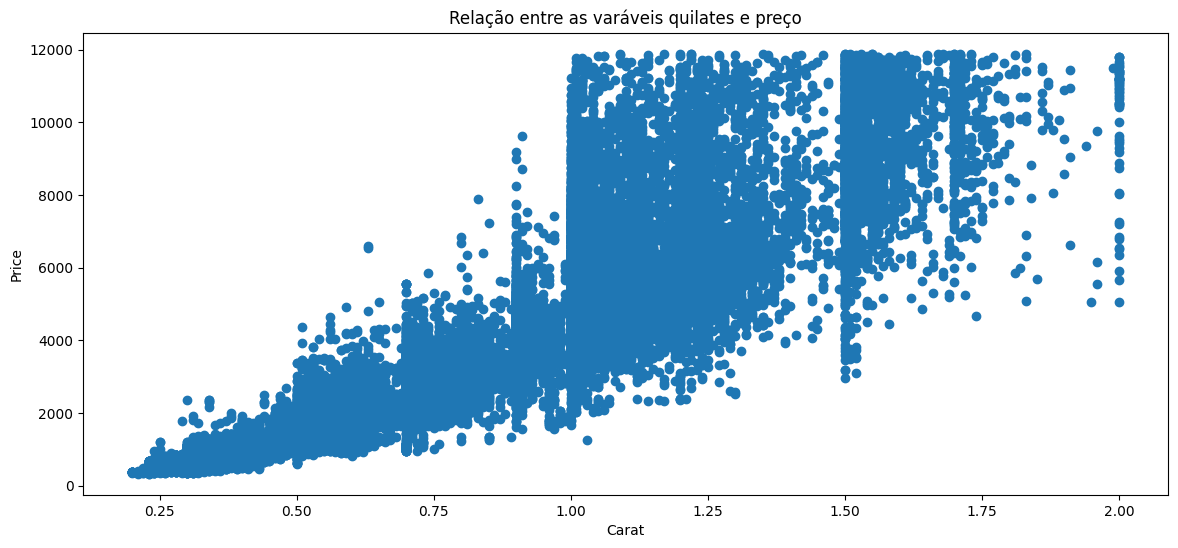

In [64]:
plt.figure(figsize=(14, 6))

plt.scatter(dados_sem_outlier.carat, dados_sem_outlier.price)
plt.title('Relação entre as varáveis quilates e preço')
plt.xlabel('Carat')
plt.ylabel('Price')

plt.show()

### Análise de normalidade

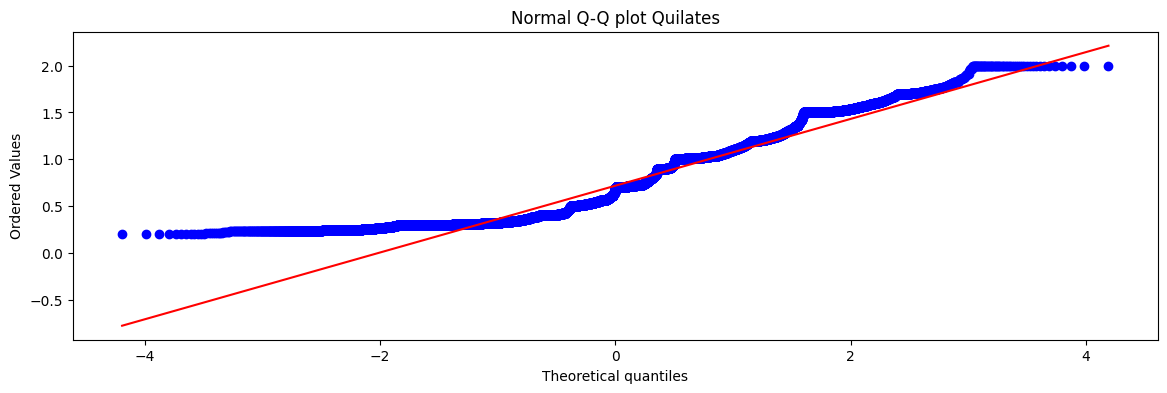

In [65]:
plt.figure(figsize=(14, 4))
stats.probplot(dados_sem_outlier['carat'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot Quilates")
plt.show()

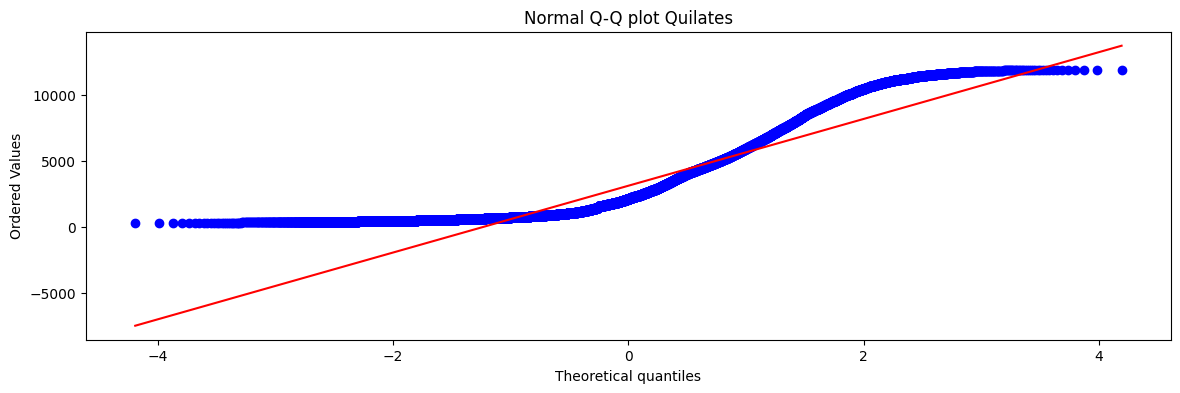

In [66]:
plt.figure(figsize=(14, 4))
stats.probplot(dados_sem_outlier['price'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot Preço")
plt.show()

- Teste Lilliefors (Kolmogorov-Smirnov)

Escolhido este ao invés de Shapiro-Wilk pois nossa amostra é grande (N > 5000)

Ho = distribuição normal: p > 0.05

Ha = ditribuição não normal: p <= 0.05

In [145]:
estatistica, p = statsmodels.stats.diagnostic.lilliefors(dados_sem_outlier.carat, dist='norm')
print(f'Estatística de teste: {estatistica} \np-valor: {p}')


Estatística de teste: 0.1258990165583 
p-valor: 0.0009999999999998899


Há evidências para rejeitar a hipótese nula, portanto os dados não devem seguir uma distribuição normal

### Correlação Linear

Como nossa distribuição não é normal, usaremos a correlação de Spearman

In [91]:
estatistica, p = stats.spearmanr(dados_sem_outlier.carat, dados_sem_outlier.price)
print(f'Coeficiente de correlação: {estatistica} \np-valor: {p}')

Coeficiente de correlação: 0.9562195627362201 
p-valor: 0.0


Correlação entre o preço e os quilates do diamante

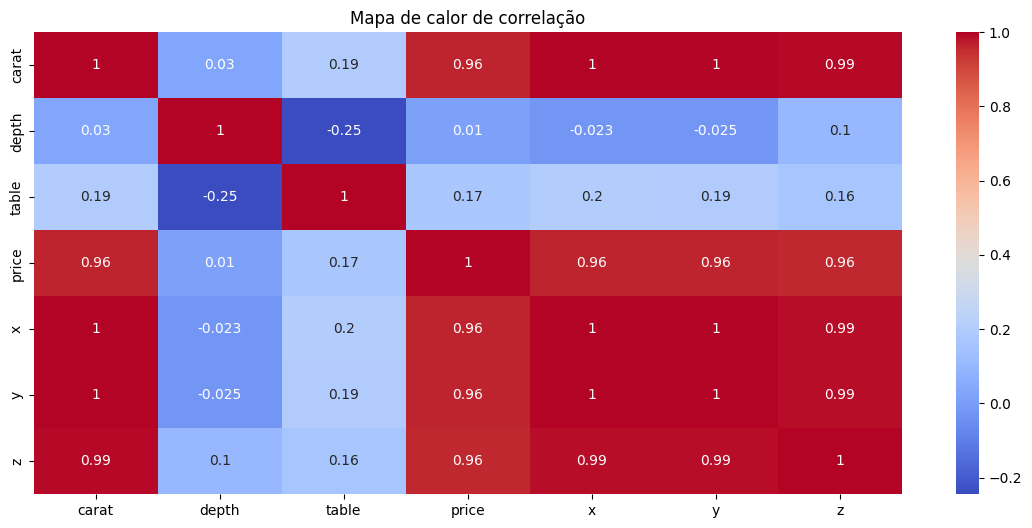

In [86]:
plt.figure(figsize=(14, 6))

sns.heatmap(dados.corr(numeric_only=True, method="spearman"), cmap="coolwarm", annot=True)
plt.title("Mapa de calor de correlação")

plt.show()

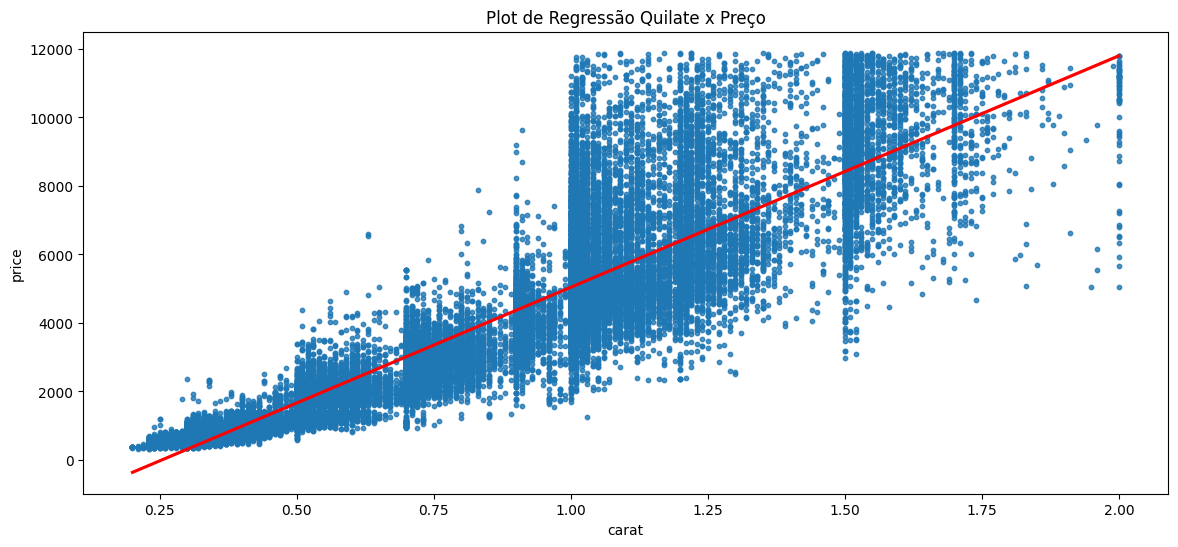

In [92]:
plt.figure(figsize=(14, 6))

sns.regplot(x="carat", y="price", data=dados_sem_outlier, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.title("Plot de Regressão Quilate x Preço")

plt.show()

### Modelo de Regressão Linear

Criação do modelo

In [118]:
regressao = smf.ols('price ~ carat', data = dados_sem_outlier).fit()

In [119]:
residuos = regressao.resid
residuos

0         486.516854
1         621.635626
2         487.516854
3          89.160537
4         -44.958235
            ...     
53935    -392.893067
53936    -392.893067
53937    -257.774294
53938   -1338.724472
53939    -595.571225
Length: 50060, dtype: float64

### 1º Pressuposto - Teste de Normalidade dos Resíduos

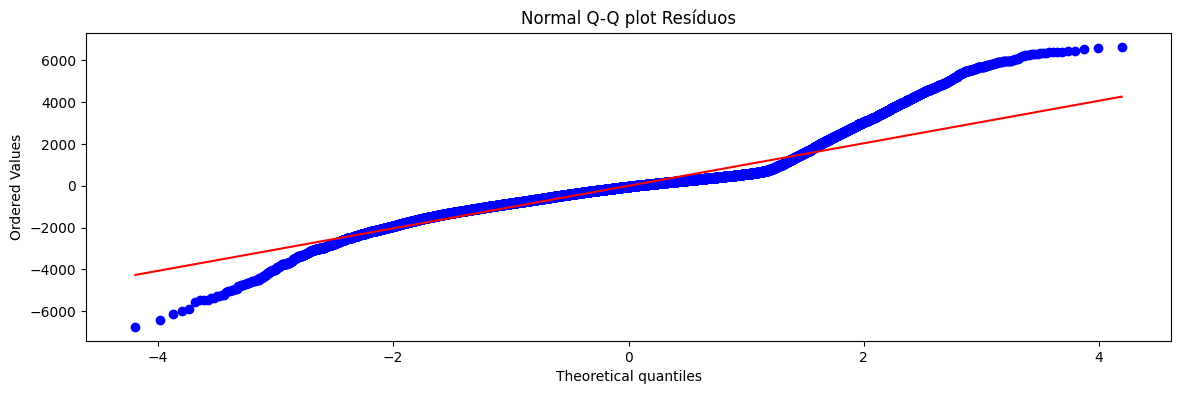

In [120]:
plt.figure(figsize=(14, 4))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Normal Q-Q plot Resíduos")
plt.show()

### 2º Pressuposto: Análise da Homocedasticidade dos Resíduos

Text(0, 0.5, 'Price')

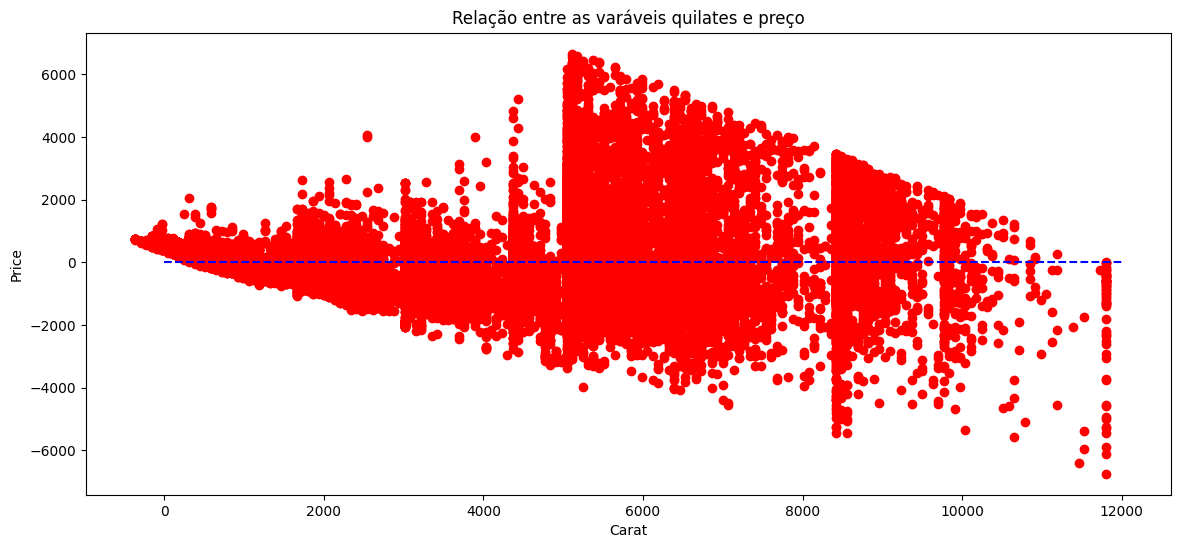

In [122]:
plt.figure(figsize=(14, 6))

plt.scatter(y=residuos, x=regressao.predict(), color='red')
plt.hlines(y=0, xmin=0, xmax=12000, linestyle='--', color='blue')
plt.title('Relação entre as varáveis quilates e preço')
plt.xlabel('Carat')
plt.ylabel('Price')

Teste Breusch-Pagan (Homodasticidade ou Heterodasticidade)

Ho = existe homocesdaticidade: p > 0.05

Ha = não existe homocesdaticidade: p <= 0.05

In [123]:
estatistica, p, f, fp = sms.het_breuschpagan(regressao.resid, regressao.model.exog)
print(f'Estatística de tests: {estatistica} \np-valor: {p} \nf-valor: {f} \nf_p-valor: {fp}')

Estatística de tests: 7327.50655209838 
p-valor: 0.0 
f-valor: 8583.639600439756 
f_p-valor: 0.0


### Outliers nos resíduos

No teste de outliers os valores devem estar dentro do intervalo de 3 e -3

In [124]:
outliers = regressao.outlier_test()

In [125]:
outliers.max()

student_resid    6.167710
unadj_p          0.999995
bonf(p)          1.000000
dtype: float64

In [126]:
outliers.min()

student_resid   -6.250563e+00
unadj_p          4.122627e-10
bonf(p)          2.063787e-05
dtype: float64

### Regressão Linear

In [127]:
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                 2.713e+05
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:28:19   Log-Likelihood:            -4.2068e+05
No. Observations:               50060   AIC:                         8.414e+05
Df Residuals:                   50058   BIC:                         8.414e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1714.3827     10.486   -163.499      0.0

Estatística t:

Ho = coeficiente igual a zero: p > 0.05 (coeficiente não validado)

H1 = coeficiente diferente de zero: p <= 0.05 (coeficiente validado)

Equação: Preço = coef intercept + coef carat * carat

R^2 ajustado = 0.844

In [129]:
coefs = pd.DataFrame(regressao.params)
coefs.columns = ['Coeficientes']
print(coefs)

           Coeficientes
Intercept  -1714.382735
carat       6755.938613


In [130]:
regressao.params

Intercept   -1714.382735
carat        6755.938613
dtype: float64

In [131]:
regressao.predict()

array([-160.51685375, -295.63562601, -160.51685375, ..., 3014.7742944 ,
       4095.72447249, 3352.57122506])

C:\Users\dpias\AppData\Local\Temp\ipykernel_14940\3370284720.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(X_plot, X_plot*regressao.params[1] + regressao.params[0], color='r')


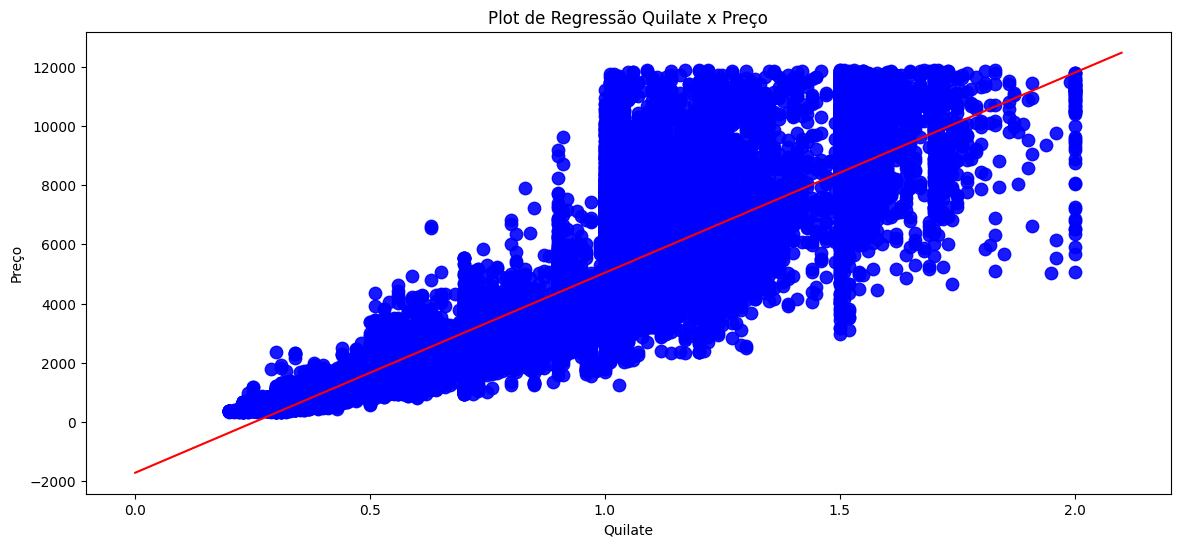

In [143]:
plt.figure(figsize=(14, 6))
plt.scatter(y=dados_sem_outlier.price, x=dados_sem_outlier.carat, color='blue', s=80, alpha=0.9)
plt.title("Plot de Regressão Quilate x Preço")
plt.xlabel('Quilate')
plt.ylabel('Preço')
X_plot = np.linspace(0, 2.1)
plt.plot(X_plot, X_plot*regressao.params[1] + regressao.params[0], color='r')
plt.show()